In [ ]:
# Import all necessary libraries for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil              # For navigating files
from google.colab import drive # For mounting google drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Data Import

In [ ]:
# Mount the Google Drive to access the shot data data .zip files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Un-zip all the data files into Google Drive
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2007.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2008.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2009.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2010.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2011.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2012.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2013.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2014.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2015.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2016.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2017.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2018.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2019.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2020.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2021.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2022.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2023.zip

Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2007.zip
  inflating: shots_2007.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2008.zip
  inflating: shots_2008.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2009.zip
  inflating: shots_2009.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2010.zip
  inflating: shots_2010.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2011.zip
  inflating: shots_2011.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2012.zip
  inflating: shots_2012.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2013.zip
  inflating: shots_2013.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2014.zip
  inflating: shots_2014.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2015.zip
  inflating: shots_2015.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2016.zip
  inflating: shots_2016.csv          
Archive:  

In [ ]:
# Define constants
SELECT_SEASONS = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
DATA_LOCATION = '/content'
CSV_BASE_NAME = 'shots_'

In [ ]:
# Initialize list of dataframes
season_dfs = []

# Iterate through each season
for iSeason in SELECT_SEASONS:

  # Create full path to the current season's shot CSV data file
  full_path_to_csv = os.path.join(DATA_LOCATION, CSV_BASE_NAME + iSeason + '.csv')

  # Create dataframe for current season and append to the running list
  season_dfs.append(pd.read_csv(full_path_to_csv))

# Concatenate all dataframes into one
shot_df = pd.concat(season_dfs, ignore_index=True)

# Data Cleaning

In [ ]:
shot_df.describe()

In [ ]:
# Get all column names
cols = shot_df.columns
for iCol in range(cols.size):
  print(cols[iCol])

shotID
homeTeamCode
awayTeamCode
season
isPlayoffGame
game_id
homeTeamWon
id
time
timeUntilNextEvent
timeSinceLastEvent
period
team
location
event
goal
shotPlayContinuedOutsideZone
shotPlayContinuedInZone
shotGoalieFroze
shotPlayStopped
shotGeneratedRebound
homeTeamGoals
awayTeamGoals
xCord
yCord
xCordAdjusted
yCordAdjusted
shotAngle
shotAngleAdjusted
shotAnglePlusRebound
shotAngleReboundRoyalRoad
shotDistance
shotType
shotOnEmptyNet
shotRebound
shotAnglePlusReboundSpeed
shotRush
speedFromLastEvent
lastEventxCord
lastEventyCord
distanceFromLastEvent
lastEventShotAngle
lastEventShotDistance
lastEventCategory
lastEventTeam
homeEmptyNet
awayEmptyNet
homeSkatersOnIce
awaySkatersOnIce
awayPenalty1TimeLeft
awayPenalty1Length
homePenalty1TimeLeft
homePenalty1Length
playerPositionThatDidEvent
playerNumThatDidEvent
playerNumThatDidLastEvent
lastEventxCord_adjusted
lastEventyCord_adjusted
timeSinceFaceoff
goalieIdForShot
goalieNameForShot
shooterPlayerId
shooterName
shooterLeftRight
shooterTimeO

In [ ]:
# List out all the columns that we wish to analyze moving forward
cols_to_keep = ['arenaAdjustedShotDistance', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'awaySkatersOnIce', 'awayTeamCode', 'event', 'homeSkatersOnIce', 'homeTeamCode', 'isHomeTeam', 'lastEventCategory', 'offWing', 'shootingTeamAverageTimeOnIce', 'shotAngleAdjusted', 'shotAngleReboundRoyalRoad', 'shotOnEmptyNet', 'shotRebound', 'shotRush', 'shotType', 'speedFromLastEvent', 'timeSinceLastEvent']

In [ ]:
# Remove all other, nonessential columns from the dataframe
for iCol in shot_df.columns:
  if iCol not in cols_to_keep:
    shot_df.drop(iCol, axis=1, inplace=True)

In [ ]:
# Remove all shots from games that do not involve the CO Avalanche
index_non_avs = shot_df[(shot_df['awayTeamCode'] != 'COL') & (shot_df['homeTeamCode'] != 'COL')].index
shot_df.drop(index_non_avs, inplace=True)
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,speedFromLastEvent,lastEventCategory,homeSkatersOnIce,awaySkatersOnIce,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,0.893890,TAKE,5,5,23.6,0,58.0,30.0,1.0,39.0
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,0.921954,SHOT,5,5,19.0,1,42.0,26.0,1.0,56.0
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,2.576941,FAC,5,5,8.0,0,14.0,12.0,1.0,81.0
398,COL,DAL,48,SHOT,41.423666,0,WRIST,0,0,0,2.750079,BLOCK,5,5,74.4,1,44.0,29.0,0.0,56.0
399,COL,DAL,5,SHOT,70.559965,1,WRIST,0,0,0,13.535139,SHOT,5,5,79.4,0,34.0,32.0,0.0,78.0
400,COL,DAL,36,SHOT,70.974394,0,WRIST,0,0,0,2.337628,GIVE,5,5,24.8,0,28.0,26.0,0.0,80.0
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,13.666667,SHOT,5,5,26.2,0,13.0,9.0,1.0,79.0
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,4.636364,FAC,5,4,11.2,0,70.0,29.0,1.0,25.0
403,COL,DAL,13,SHOT,45.881404,0,WRIST,0,0,0,5.066423,GIVE,5,4,23.5,0,45.0,32.0,0.0,58.0
404,COL,DAL,20,SHOT,47.726311,0,WRIST,0,0,0,3.988107,TAKE,5,5,30.8,1,17.0,13.0,0.0,78.0


In [ ]:
# Remove empty net shots from the dataframe, as skew shot goal results are skewed when no goalie is present
index_empty_net = shot_df[(shot_df['shotOnEmptyNet'] == 1)].index
shot_df.drop(index_empty_net, inplace=True)

In [ ]:
# Create new feature for whether or not this is an Avs home game
shot_df['isHomeGame'] = np.where(shot_df['homeTeamCode'] == 'COL', 1, 0)

In [ ]:
print(shot_df['isHomeTeam'].unique())

[1. 0.]


In [ ]:
# Remove home game shots that were taken by team that was opposing the Avalanche
index_other_team_shots = shot_df[(shot_df['isHomeGame'] == True) & (shot_df['isHomeTeam'] < 0.5)].index
shot_df.drop(index_other_team_shots, inplace=True)

In [ ]:
# Repeat the above removal for Avalanche away games
index_other_team_shots = shot_df[(shot_df['isHomeGame'] == False) & (shot_df['isHomeTeam'] > 0.5)].index
shot_df.drop(index_other_team_shots, inplace=True)

In [ ]:
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,...,lastEventCategory,homeSkatersOnIce,awaySkatersOnIce,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS,isHomeGame
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,...,TAKE,5,5,23.6,0,58.0,30.0,1.0,39.0,1
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,...,SHOT,5,5,19.0,1,42.0,26.0,1.0,56.0,1
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,...,FAC,5,5,8.0,0,14.0,12.0,1.0,81.0,1
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,...,SHOT,5,5,26.2,0,13.0,9.0,1.0,79.0,1
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,...,FAC,5,4,11.2,0,70.0,29.0,1.0,25.0,1
405,COL,DAL,27,MISS,8.914927,0,SLAP,0,0,0,...,SHOT,5,5,31.4,0,51.0,8.0,1.0,39.0,1
406,COL,DAL,13,SHOT,19.746837,0,WRIST,0,0,0,...,HIT,5,5,33.2,0,40.0,14.0,1.0,51.0,1
408,COL,DAL,9,MISS,31.429566,0,SLAP,0,0,0,...,GIVE,5,5,41.4,0,41.0,21.0,1.0,54.0,1
411,COL,DAL,18,SHOT,4.398705,0,WRIST,0,0,0,...,MISS,5,5,23.2,0,25.0,2.0,1.0,64.0,1
412,COL,DAL,1,SHOT,46.636577,1,WRIST,0,1,0,...,SHOT,5,5,24.2,1,24.0,17.0,1.0,73.0,1


In [ ]:
shot_df.shape[0]

57817

In [ ]:
# Check for indices corresponding to missing values in the dataframe
np.where(pd.isnull(shot_df))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
# Fill the missing shot types with wrist shots, as they are the most common
shot_df['shotType'].fillna('WRIST', inplace=True)

In [ ]:
# Verify the wrist shots were added for missing values
print(shot_df['shotType'].unique())

['SLAP' 'BACK' 'WRIST' 'TIP' 'WRAP' 'SNAP' 'DEFL']


In [ ]:
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,...,lastEventCategory,homeSkatersOnIce,awaySkatersOnIce,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS,isHomeGame
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,...,TAKE,5,5,23.6,0,58.0,30.0,1.0,39.0,1
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,...,SHOT,5,5,19.0,1,42.0,26.0,1.0,56.0,1
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,...,FAC,5,5,8.0,0,14.0,12.0,1.0,81.0,1
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,...,SHOT,5,5,26.2,0,13.0,9.0,1.0,79.0,1
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,...,FAC,5,4,11.2,0,70.0,29.0,1.0,25.0,1
405,COL,DAL,27,MISS,8.914927,0,SLAP,0,0,0,...,SHOT,5,5,31.4,0,51.0,8.0,1.0,39.0,1
406,COL,DAL,13,SHOT,19.746837,0,WRIST,0,0,0,...,HIT,5,5,33.2,0,40.0,14.0,1.0,51.0,1
408,COL,DAL,9,MISS,31.429566,0,SLAP,0,0,0,...,GIVE,5,5,41.4,0,41.0,21.0,1.0,54.0,1
411,COL,DAL,18,SHOT,4.398705,0,WRIST,0,0,0,...,MISS,5,5,23.2,0,25.0,2.0,1.0,64.0,1
412,COL,DAL,1,SHOT,46.636577,1,WRIST,0,1,0,...,SHOT,5,5,24.2,1,24.0,17.0,1.0,73.0,1


In [ ]:
print(shot_df['lastEventCategory'].unique())

['TAKE' 'SHOT' 'FAC' 'HIT' 'GIVE' 'MISS' 'BLOCK' 'STOP' 'PENL' 'EISTR'
 'GOAL' 'CHL' 'PEND' 'DELPEN']


In [ ]:
# Create the label column for whether or not the Avalanche shot resulted in a goal
shot_df['isGoal'] = np.where(shot_df['event'] == 'GOAL', 1, 0)

In [ ]:
# Remove features that are no longer necessary
shot_df.drop('event', axis=1, inplace=True)
shot_df.drop('shotOnEmptyNet', axis=1, inplace=True)

In [ ]:
# One-hot encode the shorthanded shots using the number of Avs and opposing players on the ice
shot_df['isShortSided'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] < x['awaySkatersOnIce'])) or
                                                        (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] > x['awaySkatersOnIce']))) else 0, axis=1)

# Repeat for even strength matchups
shot_df['isEvenStrength'] = shot_df.apply(lambda x: 1 if (x['homeSkatersOnIce'] == x['awaySkatersOnIce']) else 0, axis=1)

# Repeat for power-plays with one less opposing skater than Avs skaters on the ice
shot_df['isPowerPlay'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] == (x['awaySkatersOnIce'] + 1))) or
                                                       (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] == (x['awaySkatersOnIce'] - 1)))) else 0, axis=1)

# Repeat for power-plays with at least two less opposing skater than Avs skaters on the ice
shot_df['isExtraPowerPlay'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] >= (x['awaySkatersOnIce'] + 2))) or
                                                            (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] <= (x['awaySkatersOnIce'] - 2)))) else 0, axis=1)

In [ ]:
# Remove features that are no longer necessary
shot_df.drop('awaySkatersOnIce', axis=1, inplace=True)
shot_df.drop('homeSkatersOnIce', axis=1, inplace=True)
shot_df.drop('awayTeamCode', axis=1, inplace=True)
shot_df.drop('homeTeamCode', axis=1, inplace=True)
shot_df.drop('isHomeTeam', axis=1, inplace=True)

In [ ]:
shot_df.head(15)

,timeSinceLastEvent,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotRebound,shotRush,speedFromLastEvent,lastEventCategory,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,isHomeGame,isGoal,isShortSided,isEvenStrength,isPowerPlay,isExtraPowerPlay
395,54,30.801446,0,SLAP,0,0,0.893890,TAKE,23.6,0,58.0,30.0,39.0,1,0,0,1,0,0
396,20,38.453709,0,SLAP,0,0,0.921954,SHOT,19.0,1,42.0,26.0,56.0,1,0,0,1,0,0
397,8,57.528808,0,BACK,0,0,2.576941,FAC,8.0,0,14.0,12.0,81.0,1,0,0,1,0,0
401,12,41.185925,0,WRIST,0,0,13.666667,SHOT,26.2,0,13.0,9.0,79.0,1,0,0,1,0,0
402,11,24.034288,0,SLAP,0,0,4.636364,FAC,11.2,0,70.0,29.0,25.0,1,0,0,0,1,0
405,27,8.914927,0,SLAP,0,0,1.673648,SHOT,31.4,0,51.0,8.0,39.0,1,0,0,1,0,0
406,13,19.746837,0,WRIST,0,0,11.317108,HIT,33.2,0,40.0,14.0,51.0,1,0,0,1,0,0
408,9,31.429566,0,SLAP,0,0,6.376074,GIVE,41.4,0,41.0,21.0,54.0,1,0,0,1,0,0
411,18,4.398705,0,WRIST,0,0,6.530319,MISS,23.2,0,25.0,2.0,64.0,1,0,0,1,0,0
412,1,46.636577,1,WRIST,1,0,21.931712,SHOT,24.2,1,24.0,17.0,73.0,1,0,0,1,0,0


In [ ]:
# One-hot encode the shot type and last event categorical features
shot_df_encoded = pd.get_dummies(shot_df, columns=['shotType', 'lastEventCategory'])

In [ ]:
# Verify the one-hot encoding was successful
shot_df_encoded.head(15)

,timeSinceLastEvent,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotRebound,shotRush,speedFromLastEvent,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,...,lastEventCategory_FAC,lastEventCategory_GIVE,lastEventCategory_GOAL,lastEventCategory_HIT,lastEventCategory_MISS,lastEventCategory_PEND,lastEventCategory_PENL,lastEventCategory_SHOT,lastEventCategory_STOP,lastEventCategory_TAKE
395,54,30.801446,0,0,0,0.893890,23.6,0,58.0,30.0,...,0,0,0,0,0,0,0,0,0,1
396,20,38.453709,0,0,0,0.921954,19.0,1,42.0,26.0,...,0,0,0,0,0,0,0,1,0,0
397,8,57.528808,0,0,0,2.576941,8.0,0,14.0,12.0,...,1,0,0,0,0,0,0,0,0,0
401,12,41.185925,0,0,0,13.666667,26.2,0,13.0,9.0,...,0,0,0,0,0,0,0,1,0,0
402,11,24.034288,0,0,0,4.636364,11.2,0,70.0,29.0,...,1,0,0,0,0,0,0,0,0,0
405,27,8.914927,0,0,0,1.673648,31.4,0,51.0,8.0,...,0,0,0,0,0,0,0,1,0,0
406,13,19.746837,0,0,0,11.317108,33.2,0,40.0,14.0,...,0,0,0,1,0,0,0,0,0,0
408,9,31.429566,0,0,0,6.376074,41.4,0,41.0,21.0,...,0,1,0,0,0,0,0,0,0,0
411,18,4.398705,0,0,0,6.530319,23.2,0,25.0,2.0,...,0,0,0,0,1,0,0,0,0,0
412,1,46.636577,1,1,0,21.931712,24.2,1,24.0,17.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Define goals as the labels to predict, then convert to numpy array
goal_labels = np.array(shot_df_encoded['isGoal'])

# Remove the labels from the dataframe
shot_df_label_removed = shot_df_encoded.drop('isGoal', axis = 1)

# Capture feature names
feature_list = list(shot_df_label_removed.columns)

# Convert dataframe for features to numpy array
shot_arr = np.array(shot_df_label_removed)

In [ ]:
# Split the shot data into training and test data sets
train_shot_features, test_shot_features, train_goal_labels, test_goal_labels = train_test_split(shot_arr, goal_labels, test_size = 0.25, random_state = 55)

In [ ]:
# Verify the split was successful
print(train_shot_features.shape)
print(test_shot_features.shape)
print(train_goal_labels.shape)
print(test_goal_labels.shape)

(43362, 37)
(14455, 37)
(43362,)
(14455,)


# Random Forest Classifier

In [ ]:
# Create random forest model using 1000 decision trees
rand_forest = RandomForestClassifier(n_estimators = 1000, random_state = 55)

# Add random number column to gauge feature importance

# TO DO: look into sklearn.metrics -> Mutual information: helps with unbalanced datasets

  # helps with less common features, etc

  # scikitplot.estimators for feature importance plot

# Train the model on training data
rand_forest.fit(train_shot_features, train_goal_labels)

RandomForestClassifier(n_estimators=1000, random_state=55)

In [ ]:
# Calculate importance of all shot features
feat_imp = list(rand_forest.feature_importances_)

# Create tuple that relates the importance rating with each feature name
feat_imp_tup = [(feat, imp) for feat, imp in zip(feature_list, feat_imp)]

# Sort the tuple from most important shot feature to least important
feat_imp_tup = sorted(feat_imp_tup, key = lambda x: x[1], reverse = True)

In [ ]:
# Predict goals for the test set and output the accuracy metric
goal_predictions = rand_forest.predict(test_shot_features)
accuracy_metric = accuracy_score(test_goal_labels, goal_predictions)
print("Accuracy:", accuracy_metric)

Accuracy: 0.9318574887582152


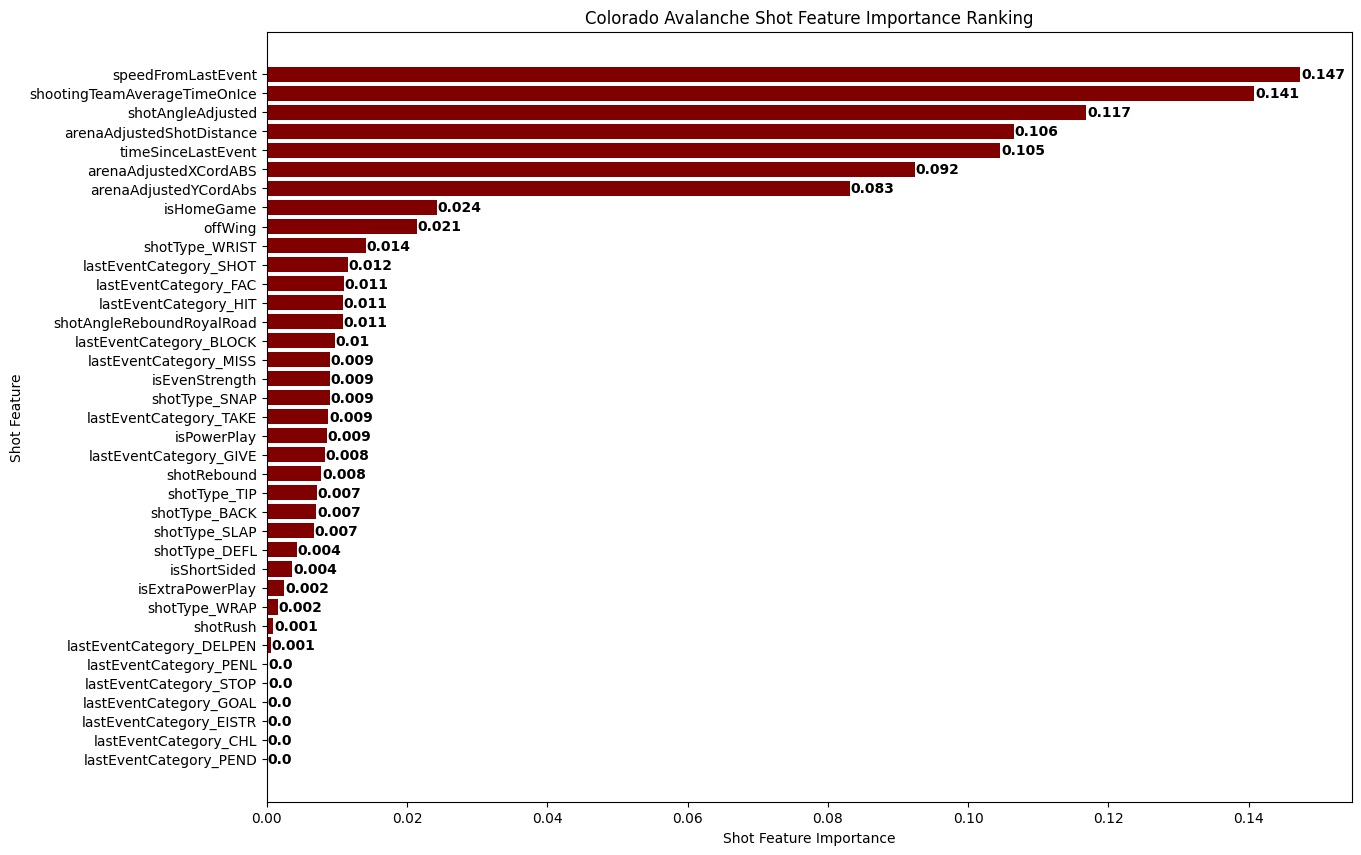

In [ ]:
# Create barplot of the feature importances
fig, ax = plt.subplots(figsize = (14, 10))
ax.barh(list(zip(*feat_imp_tup))[0], list(zip(*feat_imp_tup))[1], color = 'maroon')
ax.invert_yaxis()
for patch in ax.patches:
    plt.text(patch.get_width() + 0.0001,
             patch.get_y() + 0.63,
             str(round((patch.get_width()), 3)),
             fontsize = 10,
             fontweight = 'bold',
             color = 'black')
plt.xlabel("Shot Feature Importance")
plt.ylabel("Shot Feature")
plt.title("Colorado Avalanche Shot Feature Importance Ranking")
plt.show()

In [ ]:
# TO DO: Make new feature that indicates of the last event was a shot (missed or on goal)

# TO DO: Remove the last event category feature

# Put df into random forest and predict which are most important (classification with yes/no goal as target)

  # column of random numbers and that can be used as cutoff point

  # random forest -> plotFeatureImportance fxn

  # autoML pyCarrot -> give target as yes/no goal, will tell which algorithm works best for classification